# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo')
conjunto_datos.shape

(50000, 3517)

In [3]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=10
val_size=80
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test

datos_tr=np.zeros((X_train.shape[0]*L1B,input_output_dim_B))
for i in range(x_train.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_train[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_tr[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_trainB = datos_tr;

datos_test=np.zeros((X_test.shape[0]*L1B,input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_test[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_test[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_testB = datos_test;





print(x_trainB.shape)
print(x_testB.shape)


50000
conjunto_datos shape: (50000, 3517)
5000
40000
5000
(5000, 500)
(5000, 500)


## Network parameters:

In [4]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dim = 320  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_img = Input(shape=(img_rows*img_colsB,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_colsB*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encoded)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderB = Model(input_img, decoded)

## Prepare data into training and test set.

In [5]:
x_trainB = x_trainB.reshape(x_trainB.shape[0], img_colsB, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testB = x_testB.reshape(x_testB.shape[0], img_colsB, img_rows,1)


input_shape = (img_colsB, img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
x_trainB = x_trainB.astype('float32')
# X_val= X_val.astype('float32')
x_testB = x_testB.astype('float32')

print('X_train shape:', x_trainB.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainB
X_test=x_testB

X_train shape: (5000, 25, 20, 1)


Display 20 random training images using image

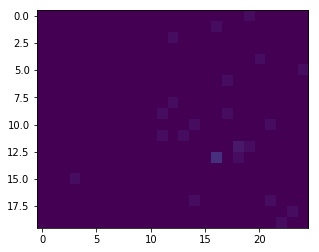

4392


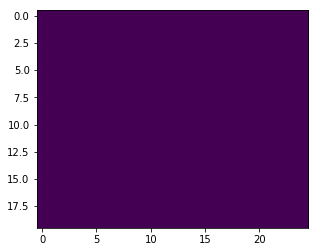

3402


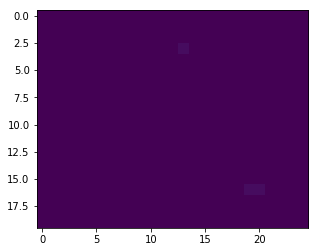

2198


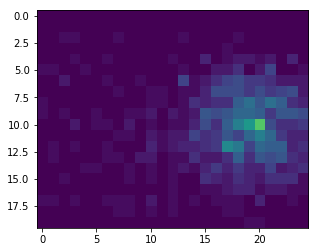

2790


In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsB]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [8]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(5000, 500)
(5000, 500)


In [9]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
# x_train_scaled = min_max_scaler.transform(x_train)
# x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
print(x_train[2413])
print(x_train_scaled[2413])
print(x_test[2413])
print(x_test_scaled[2413])

MinMaxScaler(copy=True, feature_range=(0, 1))
[ 0.  0.  2.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 

## Build the autoencoder. 

Create our metrics, for example energy

In [10]:
import keras.backend as KK
import keras.callbacks as KKcall

In [11]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [12]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoderB.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoderB.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderB.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [13]:
algoritmo='RMSprop'
experimento="scaledB_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dim,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderB.fit(x_train_scaled, x_train_scaled,
                epochs=500,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 5000 samples, validate on 5000 samples
Epoch 1/500
5000/5000 [==============================] - 2s 342us/step - loss: 20.0595 - energy_error: -93.6578 - val_loss: 21.9937 - val_energy_error: -67.5370
Epoch 2/500
5000/5000 [==============================] - 0s 33us/step - loss: 19.9044 - energy_error: -57.1363 - val_loss: 21.8926 - val_energy_error: -42.9387
Epoch 3/500
5000/5000 [==============================] - 0s 31us/step - loss: 19.8127 - energy_error: -38.9821 - val_loss: 21.8173 - val_energy_error: -30.5949
Epoch 4/500
5000/5000 [==============================] - 0s 27us/step - loss: 19.7361 - energy_error: -30.4394 - val_loss: 21.7504 - val_energy_error: -25.0408
Epoch 5/500
5000/5000 [==============================] - 0s 26us/step - loss: 19.6649 - energy_error: -26.4467 - val_loss: 21.6871 - val_energy_error: -22.1967
Epoch 6/500
5000/5000 [==============================] - 0s 29us/step - loss: 19.5968 - energy_error: -24.3662 - val_loss: 21.6261 - val_energy_error: 

5000/5000 [==============================] - 0s 28us/step - loss: 17.7582 - energy_error: -27.4531 - val_loss: 20.1078 - val_energy_error: -31.4421
Epoch 52/500
5000/5000 [==============================] - 0s 26us/step - loss: 17.7326 - energy_error: -27.3469 - val_loss: 20.0897 - val_energy_error: -31.5930
Epoch 53/500
5000/5000 [==============================] - 0s 31us/step - loss: 17.7073 - energy_error: -27.2414 - val_loss: 20.0719 - val_energy_error: -31.7397
Epoch 54/500
5000/5000 [==============================] - 0s 25us/step - loss: 17.6823 - energy_error: -27.1365 - val_loss: 20.0544 - val_energy_error: -31.8817
Epoch 55/500
5000/5000 [==============================] - 0s 28us/step - loss: 17.6577 - energy_error: -27.0326 - val_loss: 20.0373 - val_energy_error: -32.0206
Epoch 56/500
5000/5000 [==============================] - 0s 27us/step - loss: 17.6334 - energy_error: -26.9299 - val_loss: 20.0204 - val_energy_error: -32.1574
Epoch 57/500
5000/5000 [=======================

Epoch 102/500
5000/5000 [==============================] - 0s 27us/step - loss: 16.7507 - energy_error: -23.1767 - val_loss: 19.4454 - val_energy_error: -36.1948
Epoch 103/500
5000/5000 [==============================] - 0s 26us/step - loss: 16.7350 - energy_error: -23.1131 - val_loss: 19.4358 - val_energy_error: -36.2392
Epoch 104/500
5000/5000 [==============================] - 0s 33us/step - loss: 16.7195 - energy_error: -23.0504 - val_loss: 19.4263 - val_energy_error: -36.2826
Epoch 105/500
5000/5000 [==============================] - 0s 28us/step - loss: 16.7041 - energy_error: -22.9886 - val_loss: 19.4169 - val_energy_error: -36.3251
Epoch 106/500
5000/5000 [==============================] - 0s 23us/step - loss: 16.6888 - energy_error: -22.9276 - val_loss: 19.4075 - val_energy_error: -36.3660
Epoch 107/500
5000/5000 [==============================] - 0s 24us/step - loss: 16.6736 - energy_error: -22.8671 - val_loss: 19.3982 - val_energy_error: -36.4052
Epoch 108/500
5000/5000 [===

5000/5000 [==============================] - 0s 27us/step - loss: 16.0748 - energy_error: -20.6589 - val_loss: 19.0460 - val_energy_error: -37.2991
Epoch 153/500
5000/5000 [==============================] - 0s 27us/step - loss: 16.0630 - energy_error: -20.6189 - val_loss: 19.0393 - val_energy_error: -37.2984
Epoch 154/500
5000/5000 [==============================] - 0s 32us/step - loss: 16.0513 - energy_error: -20.5791 - val_loss: 19.0327 - val_energy_error: -37.2966
Epoch 155/500
5000/5000 [==============================] - 0s 28us/step - loss: 16.0397 - energy_error: -20.5393 - val_loss: 19.0261 - val_energy_error: -37.2939
Epoch 156/500
5000/5000 [==============================] - 0s 28us/step - loss: 16.0281 - energy_error: -20.4996 - val_loss: 19.0195 - val_energy_error: -37.2899
Epoch 157/500
5000/5000 [==============================] - 0s 24us/step - loss: 16.0165 - energy_error: -20.4598 - val_loss: 19.0129 - val_energy_error: -37.2850
Epoch 158/500
5000/5000 [=================

5000/5000 [==============================] - 0s 30us/step - loss: 15.5435 - energy_error: -18.8825 - val_loss: 18.7527 - val_energy_error: -37.1714
Epoch 203/500
5000/5000 [==============================] - 0s 28us/step - loss: 15.5339 - energy_error: -18.8529 - val_loss: 18.7476 - val_energy_error: -37.1761
Epoch 204/500
5000/5000 [==============================] - 0s 26us/step - loss: 15.5244 - energy_error: -18.8235 - val_loss: 18.7425 - val_energy_error: -37.1827
Epoch 205/500
5000/5000 [==============================] - 0s 31us/step - loss: 15.5149 - energy_error: -18.7944 - val_loss: 18.7374 - val_energy_error: -37.1901
Epoch 206/500
5000/5000 [==============================] - 0s 25us/step - loss: 15.5054 - energy_error: -18.7655 - val_loss: 18.7323 - val_energy_error: -37.1990
Epoch 207/500
5000/5000 [==============================] - 0s 25us/step - loss: 15.4960 - energy_error: -18.7370 - val_loss: 18.7273 - val_energy_error: -37.2068
Epoch 208/500
5000/5000 [=================

5000/5000 [==============================] - 0s 29us/step - loss: 15.0996 - energy_error: -17.6331 - val_loss: 18.5160 - val_energy_error: -37.4889
Epoch 253/500
5000/5000 [==============================] - 0s 28us/step - loss: 15.0913 - energy_error: -17.6112 - val_loss: 18.5117 - val_energy_error: -37.4891
Epoch 254/500
5000/5000 [==============================] - 0s 28us/step - loss: 15.0831 - energy_error: -17.5908 - val_loss: 18.5074 - val_energy_error: -37.4849
Epoch 255/500
5000/5000 [==============================] - 0s 24us/step - loss: 15.0749 - energy_error: -17.5692 - val_loss: 18.5031 - val_energy_error: -37.4856
Epoch 256/500
5000/5000 [==============================] - 0s 30us/step - loss: 15.0667 - energy_error: -17.5490 - val_loss: 18.4988 - val_energy_error: -37.4814
Epoch 257/500
5000/5000 [==============================] - 0s 27us/step - loss: 15.0585 - energy_error: -17.5275 - val_loss: 18.4945 - val_energy_error: -37.4824
Epoch 258/500
5000/5000 [=================

5000/5000 [==============================] - 0s 25us/step - loss: 14.7133 - energy_error: -16.6391 - val_loss: 18.3164 - val_energy_error: -37.1933
Epoch 303/500
5000/5000 [==============================] - 0s 25us/step - loss: 14.7061 - energy_error: -16.6207 - val_loss: 18.3128 - val_energy_error: -37.1838
Epoch 304/500
5000/5000 [==============================] - 0s 29us/step - loss: 14.6989 - energy_error: -16.6030 - val_loss: 18.3091 - val_energy_error: -37.1724
Epoch 305/500
5000/5000 [==============================] - 0s 29us/step - loss: 14.6917 - energy_error: -16.5850 - val_loss: 18.3055 - val_energy_error: -37.1625
Epoch 306/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.6845 - energy_error: -16.5674 - val_loss: 18.3018 - val_energy_error: -37.1508
Epoch 307/500
5000/5000 [==============================] - 0s 32us/step - loss: 14.6773 - energy_error: -16.5497 - val_loss: 18.2982 - val_energy_error: -37.1404
Epoch 308/500
5000/5000 [=================

5000/5000 [==============================] - 0s 24us/step - loss: 14.3683 - energy_error: -15.8200 - val_loss: 18.1447 - val_energy_error: -36.9977
Epoch 353/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.3617 - energy_error: -15.8056 - val_loss: 18.1414 - val_energy_error: -36.9970
Epoch 354/500
5000/5000 [==============================] - 0s 32us/step - loss: 14.3551 - energy_error: -15.7911 - val_loss: 18.1382 - val_energy_error: -36.9962
Epoch 355/500
5000/5000 [==============================] - 0s 28us/step - loss: 14.3486 - energy_error: -15.7765 - val_loss: 18.1350 - val_energy_error: -36.9985
Epoch 356/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.3420 - energy_error: -15.7628 - val_loss: 18.1318 - val_energy_error: -36.9980
Epoch 357/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.3355 - energy_error: -15.7482 - val_loss: 18.1286 - val_energy_error: -37.0016
Epoch 358/500
5000/5000 [=================

5000/5000 [==============================] - 0s 32us/step - loss: 14.0555 - energy_error: -15.1396 - val_loss: 17.9953 - val_energy_error: -37.0202
Epoch 403/500
5000/5000 [==============================] - 0s 25us/step - loss: 14.0495 - energy_error: -15.1249 - val_loss: 17.9924 - val_energy_error: -37.0271
Epoch 404/500
5000/5000 [==============================] - 0s 25us/step - loss: 14.0436 - energy_error: -15.1137 - val_loss: 17.9896 - val_energy_error: -37.0165
Epoch 405/500
5000/5000 [==============================] - 0s 28us/step - loss: 14.0377 - energy_error: -15.0994 - val_loss: 17.9867 - val_energy_error: -37.0173
Epoch 406/500
5000/5000 [==============================] - 0s 34us/step - loss: 14.0317 - energy_error: -15.0874 - val_loss: 17.9838 - val_energy_error: -37.0111
Epoch 407/500
5000/5000 [==============================] - 0s 26us/step - loss: 14.0258 - energy_error: -15.0735 - val_loss: 17.9810 - val_energy_error: -37.0140
Epoch 408/500
5000/5000 [=================

5000/5000 [==============================] - 0s 24us/step - loss: 13.7690 - energy_error: -14.5580 - val_loss: 17.8631 - val_energy_error: -37.2428
Epoch 453/500
5000/5000 [==============================] - 0s 35us/step - loss: 13.7635 - energy_error: -14.5473 - val_loss: 17.8607 - val_energy_error: -37.2368
Epoch 454/500
5000/5000 [==============================] - 0s 24us/step - loss: 13.7580 - energy_error: -14.5355 - val_loss: 17.8583 - val_energy_error: -37.2401
Epoch 455/500
5000/5000 [==============================] - 0s 24us/step - loss: 13.7525 - energy_error: -14.5253 - val_loss: 17.8559 - val_energy_error: -37.2329
Epoch 456/500
5000/5000 [==============================] - 0s 30us/step - loss: 13.7470 - energy_error: -14.5133 - val_loss: 17.8535 - val_energy_error: -37.2364
Epoch 457/500
5000/5000 [==============================] - 0s 28us/step - loss: 13.7416 - energy_error: -14.5030 - val_loss: 17.8512 - val_energy_error: -37.2295
Epoch 458/500
5000/5000 [=================

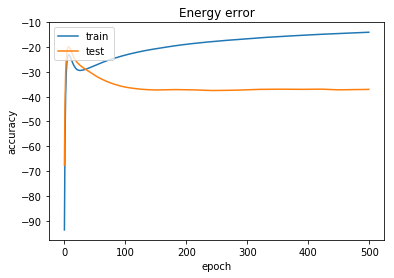

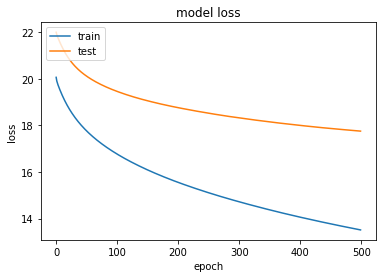

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

5000/5000 [==============================] - 0s 46us/step


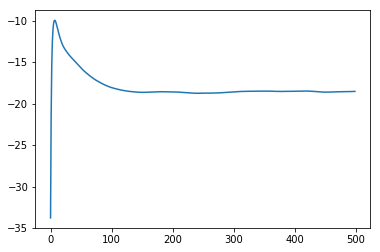

In [15]:
import pandas as pd 
autoencoderB.evaluate(x=x_test_scaled,y=x_test_scaled)
D=metrics.get_data()


energies=pd.DataFrame(D).values.reshape(len(D))
valores=len(energies)
plt.plot(range(valores),energies) 

plt.show()

In [16]:
autoencoderB.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dim,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [17]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [18]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
# decoded_imgs_scaled = autoencoderB.predict(x_test_min_max)
decoded_imgs_scaled = autoencoderB.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled)
# decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


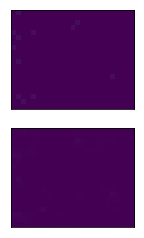

In [43]:
n = 1  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsB,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])
